In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Model,Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.applications.vgg16 import preprocess_input,VGG16
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,EarlyStopping
import visualkeras
from PIL import ImageFont

In [2]:
from tensorflow.keras.utils import to_categorical

In [3]:
pip install visualkeras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Hello\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
seed_constant = 27
random.seed(seed_constant)

In [5]:
img_height=224
img_width=224

In [6]:
def image_preprocessing(img_path):
    img = cv2.imread(img_path)
    
    # Resize the image
    resized_img = cv2.resize(img, (img_height, img_width))
    
    # Normalize the image and convert to float32
    normalized_img = resized_img.astype('float32') / 255.0
    
    return normalized_img


In [7]:
def label_extraction(img_name):
 '''
 This function will extract age from image name and return the class index by performing integer division (by 25).
 Args:
 img_name: The name of the image.
 Returns:
 class_index: An integer representing the age class.
 '''
 #Extract age 
 age=int(img_name.split('_')[0])
 #Class index dividing by 25
 class_index=age//25
 return class_index

In [8]:
def create_dataset():
 
 
 '''
 This function will create the dataset.
 Returns:
 features: A list containing the preprocessed images.
 labels: A list containing the class indexes.
 '''
 
 
 #Declare empty lists to store features and labels.
 
 features=[]
 labels=[]
 img_dir = 'UTKface/UTKFace'
 for img_name in all_img_names:
 
   #Path of the image
   img_path=os.path.join(img_dir,img_name)
 
   #Get the preprocessed image
   preprocessed_img=image_preprocessing(img_path)
 
   #Get the class index
   class_index=label_extraction(img_name)
 
   #Append data into appropriate lists
   features.append(preprocessed_img)
   labels.append(class_index)
 
 
 #Convert lists to numpy arrays
 features=np.asarray(features)
 labels=np.asarray(labels)
 
 return features,labels

In [9]:
import os
import cv2
import numpy as np

img_dir = "UTKface/UTKFace"

# List all image filenames in the directory
all_img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Select 8000 random images
num_images = 15000
selected_img_names = random.sample(all_img_names, min(num_images, len(all_img_names)))

# Generator function to load images in batches
def data_generator(img_dir, img_names, batch_size=32):
    num_batches = len(img_names) // batch_size
    while True:  # Loop indefinitely (useful for model training)
        for i in range(num_batches):
            batch_img_names = img_names[i * batch_size:(i + 1) * batch_size]
            batch_features = []
            batch_labels = []

            for img_name in batch_img_names:
                img_path = os.path.join(img_dir, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (224, 224))  # Resize image
                img = img.astype('float32') / 255.0  # Normalize
                batch_features.append(img)
                
                # Extract label (modify this according to your logic)
                label = label_extraction(img_name)
                batch_labels.append(label)

            yield np.array(batch_features), np.array(batch_labels)

# Example of using the generator
batch_size = 64
train_generator = data_generator(img_dir, selected_img_names, batch_size)

# Get one batch of data
features, labels = next(train_generator)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Features shape: (64, 224, 224, 3)
Labels shape: (64,)


In [10]:
encoded_labels=to_categorical(labels)

In [11]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, encoded_labels,test_size = 0.2, shuffle = True,random_state = seed_constant)

In [12]:
#add preprocessing layer at the front of VGG16
vgg = VGG16(input_shape=features_train.shape[1:], weights='imagenet', include_top=False)

#Prevent training already trained layers
for layer in vgg.layers:
    layer.trainable = False

#for layer in vgg.layers[-4:]:  # Unfreeze the last 4 layers
 #   layer.trainable = True

#Add flatten layer
x = Flatten()(vgg.output)

#More Dense layers

#Use weight regularization(L2 vector norm) and dropout layers to reduce overfitting
x=Dense(1000,activation="relu",kernel_regularizer=l2(0.001))(x)
x=Dropout(0.5)(x)

x=Dense(256,activation="relu",kernel_regularizer=l2(0.001))(x)
x=Dropout(0.5)(x)

#Dense layer with number of nuerons equals to number of classes.
prediction = Dense(labels_train.shape[1], activation='softmax')(x)

#Create the model object
model = Model(inputs=vgg.input, outputs=prediction)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │    25,089,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,02

 Total params: 40,060,972 (152.82 MB)

 Trainable params: 25,346,284 (96.69 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# checkpointeights
filepath = "C:/Users/Hello/Downloads/vgg16_weights_best_model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#Callbacks
callbacks_list=[early_stopping_callback,checkpoint]

# Compile the model and specify loss function, optimizer and metrics values to the model
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])

# Start training the model.
history = model.fit(x = features_train, y = labels_train, epochs = 50, shuffle = True, validation_split = 0.2, callbacks = callbacks_list )

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2062 - loss: 4.8745  
Epoch 1: val_accuracy improved from -inf to 0.54545, saving model to C:/Users/Hello/Downloads/vgg16_weights_best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 10s/step - accuracy: 0.2125 - loss: 5.0076 - val_accuracy: 0.5455 - val_loss: 8.3201
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4500 - loss: 10.0164
Epoch 2: val_accuracy did not improve from 0.54545
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step - accuracy: 0.4333 - loss: 10.1490 - val_accuracy: 0.3636 - val_loss: 5.5095
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3781 - loss: 7.8302
Epoch 3: val_accuracy did not improve from 0.54545
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.3688 - loss: 7.8535 - val_accuracy: 0.5455 - val_loss: 3.8269
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5000 - loss: 6.5426
Epoch 4: val_accuracy did not improve from 0.54545
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.500

In [14]:
import shutil

total, used, free = shutil.disk_usage("/")
print(f"Free space: {free // (2**30)} GiB")


Free space: 19 GiB


In [15]:
model_evaluation_history = model.evaluate(features_test, labels_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4615 - loss: 3.4324


In [16]:
def predict_on_image(img_path):
    
    #Preprocess image 
    preprocessed_img=image_preprocessing(img_path)

    #Reshape
    reshaped_img=np.reshape(preprocessed_img,(1,img_height,img_width,3))
    
    # Passing the img to the model and get the predicted probabilities
    predicted_labels_probabilities=model.predict(reshaped_img)
    # Get the class index with highest probability.
    class_index=np.argmax(predicted_labels_probabilities)
    #Get age class 
    age_class=str(class_index*25)+"-"+str((class_index+1)*25-1)
    
    return age_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


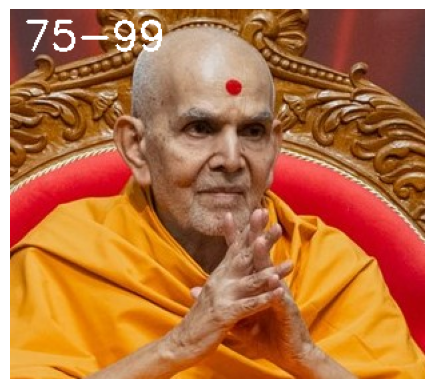

In [18]:
# New path of the sample image dataset
new_sample_dir = "MSM"

# All sample image names in the new directory
new_sample_img_names = os.listdir(new_sample_dir)

for counter, new_sample_img_name in enumerate(new_sample_img_names):
    # Path of the selected image
    new_sample_path = os.path.join(new_sample_dir, new_sample_img_name)

    # Get the prediction
    predicted_age_class = predict_on_image(new_sample_path)

    # Read sample image in BGR format
    new_sample_img_bgr = cv2.imread(new_sample_path)

    # Convert it into RGB format
    new_sample_img_rgb = cv2.cvtColor(new_sample_img_bgr, cv2.COLOR_BGR2RGB)

    # Write predicted age class on top of the image
    cv2.putText(new_sample_img_rgb, predicted_age_class, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the selected image
    plt.imshow(new_sample_img_rgb)
    plt.axis('off')
    plt.show()